In [1]:
source_size =  4.3350376922e+00
tkin = 7.9842254347e+01 # good test is 79
Ntot = 1.1061155735e+17  # good test is 1.1e17
vwidthfwhm = 4.2101396644e+00
vwidth = vwidthfwhm / np.sqrt(8*np.log(2))
vcen = -1.1000000000e+00
tbg = 2.73

In [2]:
import sys
import os
## get path of current directory
LocalPath = os.getcwd() + "/"

with open("CO_pure.molfit", "w") as fh:
    fh.write(f"""
%============================================================================================================================
%
% define molecules and their components:
%
%============================================================================================================================
%    source size:                 T_kin:               N_tot:            V_width:                V_off:   CFFlag:    keyword:
%       [arcsec]:                   [K]:              [cm-2]:            [km /s]:              [km /s]:       []:         []:
CO;v=0;           1
 {source_size}       {tkin}     {Ntot}     {vwidthfwhm}    {vcen}         c
""")
# get path of XCLASS directory
XCLASSRootDir = str(os.environ.get('XCLASSRootDir', '')).strip()
XCLASSRootDir = os.path.normpath(XCLASSRootDir) + "/"

# extend sys.path variable
NewPath = XCLASSRootDir + "build_tasks/"
if (not NewPath in sys.path):
    sys.path.append(NewPath)

import task_myXCLASS

# define path and name of molfit file
#DEFAULT MolfitsFileName = LocalPath + "files/my_molecules.molfit"
MolfitsFileName = LocalPath + 'CO_pure.molfit'



# define freq. step (in MHz)
FreqStep = 0.1

# depending on parameter "Inter_Flag" define beam size (in arcsec)
# (Inter_Flag = True) or size of telescope (in m) (Inter_Flag = False)
TelescopeSize = 1.0 # arcseconds

# define beam minor axis length (in arsec)
BMIN = None

# define beam major axis length (in arsec)
BMAJ = None

# define beam position angle (in degree)
BPA = None

# interferrometric data?
Inter_Flag = True

# define red shift
Redshift = None

# BACKGROUND: describe continuum with tBack and tslope only
t_back_flag = True

# BACKGROUND: define background temperature (in K)
tBack = tbg

# BACKGROUND: define temperature slope (dimensionless)
tslope = 0.0

# BACKGROUND: define path and name of ASCII file describing continuum as function
#             of frequency
BackgroundFileName = ""

# DUST: define hydrogen column density (in cm^(-2))
N_H = 1.e22

# DUST: define spectral index for dust (dimensionless)
beta_dust = 0.0

# DUST: define kappa at 1.3 mm (cm^(2) g^(-1))
kappa_1300 = 0.0

# DUST: define path and name of ASCII file describing dust opacity as
#       function of frequency
DustFileName = ""

# FREE-FREE: define electronic temperature (in K)
Te_ff = None

# FREE-FREE: define emission measure (in pc cm^(-6))
EM_ff = None

# SYNCHROTRON: define kappa of energy spectrum of electrons (electrons m^(−3) GeV^(-1))
kappa_sync = None

# SYNCHROTRON: define magnetic field (in Gauss)
B_sync = None

# SYNCHROTRON: energy spectral index (dimensionless)
p_sync = None

# SYNCHROTRON: thickness of slab (in AU)
l_sync = None

# PHEN-CONT: define phenomenological function which is used to describe
#            the continuum
ContPhenFuncID = None

# PHEN-CONT: define first parameter for phenomenological function
ContPhenFuncParam1 = None

# PHEN-CONT: define second parameter for phenomenological function
ContPhenFuncParam2 = None

# PHEN-CONT: define third parameter for phenomenological function
ContPhenFuncParam3 = None

# PHEN-CONT: define fourth parameter for phenomenological function
ContPhenFuncParam4 = None

# PHEN-CONT: define fifth parameter for phenomenological function
ContPhenFuncParam5 = None

# use iso ratio file?
iso_flag = True

# define path and name of iso ratio file
#DEFAULT IsoTableFileName = LocalPath + "files/my_isonames.txt"
IsoTableFileName = LocalPath + "my_isonames.txt"

# define path and name of file describing Non-LTE parameters
CollisionFileName = ""

# define number of pixels in x-direction (used for sub-beam description)
NumModelPixelXX = 100

# define number of pixels in y-direction (used for sub-beam description)
NumModelPixelYY = 100

# take local-overlap into account or not
LocalOverlapFlag = False

# disable sub-beam description
NoSubBeamFlag = True

# define path and name of database file
dbFilename = ""

# define rest freq. (in MHz)
RestFreq = 0.0

# define v_lsr (in km/s)
vLSR = 0.0

In [3]:
frequencies = np.array([115271.2018,  230538.0000,  345795.9899, 461040.7682, 576267.9305, 691473.0763, 806651.8060, 921799.7000, 1036912.3930,
                       1151985.4520, 1267014.4860, 1381995.1050, 1496922.9090])

frequencies = frequencies[:,None] * np.array([1-20/3e5, 1+25/3e5])[None,:]
results = []

for FreqMin, FreqMax in frequencies:

    ## call myXCLASS function
    modeldata, log, TransEnergies, IntOpt, JobDir = task_myXCLASS.myXCLASS(
                                                FreqMin, FreqMax, FreqStep,
                                                TelescopeSize, BMIN, BMAJ,
                                                BPA, Inter_Flag, Redshift,
                                                t_back_flag, tBack, tslope,
                                                BackgroundFileName,
                                                N_H, beta_dust, kappa_1300,
                                                DustFileName, Te_ff, EM_ff,
                                                kappa_sync, B_sync, p_sync,
                                                l_sync, ContPhenFuncID,
                                                ContPhenFuncParam1,
                                                ContPhenFuncParam2,
                                                ContPhenFuncParam3,
                                                ContPhenFuncParam4,
                                                ContPhenFuncParam5,
                                                MolfitsFileName, iso_flag,
                                                IsoTableFileName,
                                                CollisionFileName,
                                                NumModelPixelXX,
                                                NumModelPixelYY,
                                                LocalOverlapFlag,
                                                NoSubBeamFlag,
                                                dbFilename,
                                                RestFreq, vLSR)
    results.append( (modeldata, log, TransEnergies, IntOpt, JobDir) )


Start function myXCLASS:


Creating job directory for function myXCLASS: /orange/adamginsburg/software/XCLASS-Interface/run/myXCLASS/job__04-09-2021__13-39-03__292147699/ .. done!

All files of the current myXCLASS run are stored here!


Set environment variable MAGIXTempDirectory =  /orange/adamginsburg/software/XCLASS-Interface/programs/MAGIX/temp/
Analyze molfit file .. done!


Check, if names of molecules in molfit file are included in XCLASS database .. done!




Import calculated myXCLASS spectrum .. done!

Read in intensities for each molecule and for each component .. done!

Read in optical depths for each molecule and for each component .. done!

All files of the current myXCLASS run are stored in the job directory /orange/adamginsburg/software/XCLASS-Interface/run/myXCLASS/job__04-09-2021__13-39-03__292147699/!



Start function myXCLASS:


Creating job directory for function myXCLASS: /orange/adamginsburg/software/XCLASS-Interface/run/myXCLASS/job__04-09-2021__13-39-03__292

In [4]:
import pyspeckit

In [5]:
from astropy import units as u

In [6]:
%matplotlib inline
import pylab as pl

In [7]:
xclass_spectra = pyspeckit.Spectra([pyspeckit.Spectrum(data=modeldata.T[1]*u.K, xarr=modeldata.T[0]*u.MHz)
                                    for (modeldata, log, TransEnergies, IntOpt, JobDir) in results])

INFO: Creating spectra [pyspeckit.spectrum.classes]
INFO: Concatenating data [pyspeckit.spectrum.classes]


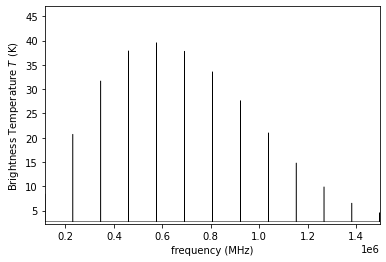

In [8]:
xclass_spectra.plotter()

In [9]:
from molsim.classes import Workspace, Catalog, Transition, Level, Molecule, PartitionFunction, Spectrum, Simulation, Continuum, Source, Observatory, Observation, Iplot, Trace
from molsim.file_handling import load_mol, load_obs, load_multi_obs

In [10]:
co = load_mol('co.cat', 
              type='SPCAT',
              qpart_file='co.qpart')
co_src = Source(column = Ntot, #column density in cm-2
                Tex = tkin, #excitation temperature in K
                dV = vwidthfwhm, #FWHM linewidth in km/s
                velocity = vcen, #vlsr in km/s
                size = 1E20, #source size in arcseconds; default is 1E20 so no beam dilution is considered.
                continuum = Continuum(params=tbg), 
                #a continuum object to define the background temperature. Default 2.7 K.
                #This can be substantially more flexible if needed - see the Continuum class object.
                )
co_sim = Simulation(  observation = Observation(), #a default Observation object (see note below)
                      source = co_src, #the source of emission
                      ll = frequencies.min(), #lower limit
                      ul = frequencies.max(), #upper limit
                      res = FreqStep, #resolution in MHz
                      mol = co, #molecule
)
molsim_sp = pyspeckit.Spectrum(xarr=co_sim.spectrum.freq_profile*u.MHz, data=co_sim.spectrum.int_profile*u.K)

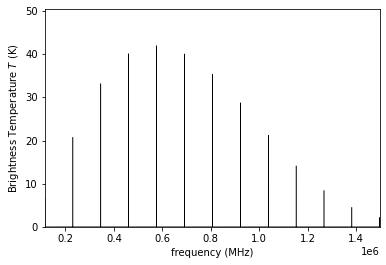

In [11]:
molsim_sp.plotter()

In [12]:
from pyspeckit.spectrum.models import lte_molecule
from pyspeckit.spectrum.models.lte_molecule import get_molecular_parameters, generate_model, generate_fitter

In [13]:
FreqMin = xclass_spectra.xarr.min()
FreqMax = xclass_spectra.xarr.max()

In [14]:
from astropy.table import Table

In [15]:
Jfreqs, Jaij, Jdeg, JEU, Jpartfunc = get_molecular_parameters('CO',
                                                              catalog='JPL',
                                                              fmin=FreqMin,
                                                              fmax=FreqMax)
def modfunc_JPL(xarr, vcen, width, tex, column):
    return generate_model(xarr, vcen=vcen, width=width, tex=tex, column=column, freqs=Jfreqs, aij=Jaij,
                          deg=Jdeg, EU=JEU, partfunc=Jpartfunc, tbg=tbg)

#print(Jpartfunc(tkin))
#Table([Jfreqs, Jdeg, JEU, Jaij])

In [16]:
freqs, aij, deg, EU, partfunc = get_molecular_parameters('CO, v=0',
                                                         catalog='CDMS',
                                                         fmin=FreqMin,
                                                         fmax=FreqMax)
def modfunc_CDMS(xarr, vcen, width, tex, column):
    return generate_model(xarr, vcen=vcen, width=width, tex=tex, column=column, freqs=freqs, aij=aij,
                          deg=deg, EU=EU, partfunc=partfunc, tbg=tbg)

#print(partfunc(tkin))
#Table([freqs, deg, EU, aij])

In [17]:
# sanity check: all CDMS & JPL EU's are the same
assert np.all(JEU[:9] - EU[:9] == 0)

In [18]:
Jaij[:9] - aij[:9]

array([0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [19]:
from astropy import log
#log.setLevel('DEBUG')
JM = modfunc_JPL(xclass_spectra.xarr, vcen, width=vwidth, tex=tkin, column=Ntot)
CM = modfunc_CDMS(xclass_spectra.xarr, vcen, width=vwidth, tex=tkin, column=Ntot)
#log.setLevel('INFO')

In [20]:
model_JPL = pyspeckit.Spectrum(xarr=xclass_spectra.xarr, data=JM*u.K)
model_CDMS = pyspeckit.Spectrum(xarr=xclass_spectra.xarr, data=CM*u.K)

In [21]:
Ntot < 30

False

(0.0, 301.0)

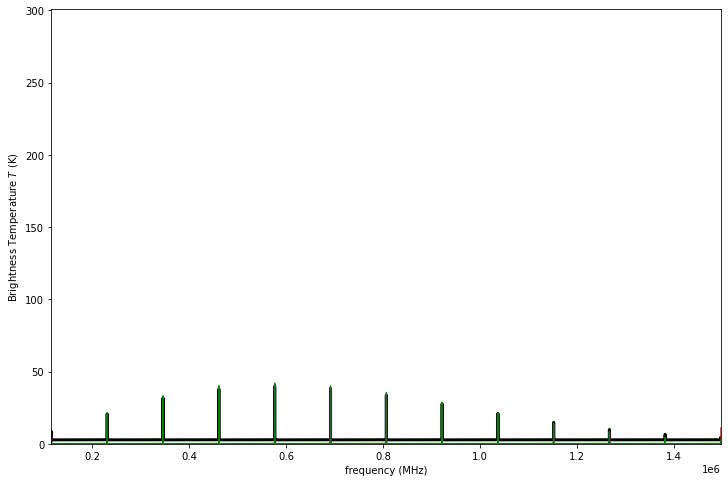

In [22]:
fig = pl.figure(figsize=(12,8))
xclass_spectra.plotter(figure=fig, linewidth=3)
ax = xclass_spectra.plotter.axis
model_JPL.plotter(clear=False, color='r', axis=ax, alpha=0.75, linewidth=1.75)
model_CDMS.plotter(clear=False, color='b', axis=ax, alpha=0.75, linewidth=1.5)
molsim_sp.plotter(clear=False, color='g', axis=ax, linewidth=1.25)
ax.set_ylim([0,301])

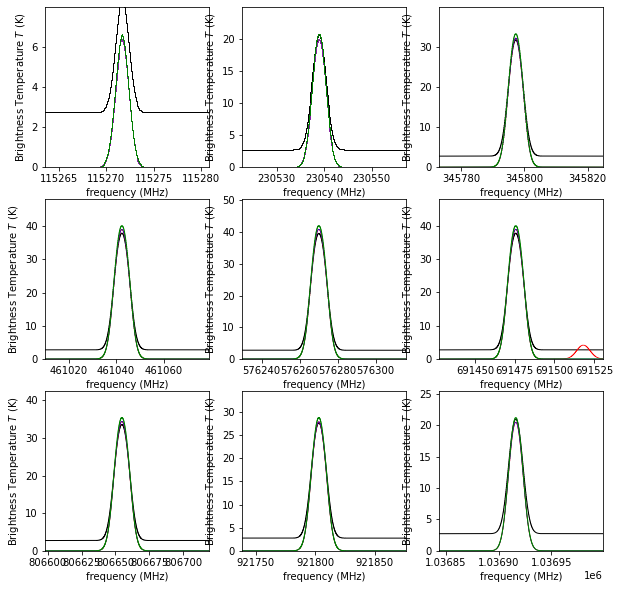

In [23]:
fig = pl.figure(figsize=(10,10))
for ii,(fmin, fmax) in enumerate(frequencies):
    if ii+1 > 9:
        break
    ax = pl.subplot(3,3,ii+1)
    xclass_spectra.plotter(axis=ax, clear=False, linewidth=1)
    model_JPL.plotter(color='r', axis=ax, clear=False, xmin=fmin, xmax=fmax, linewidth=0.75)
    model_CDMS.plotter(color='b', axis=ax, clear=False, xmin=fmin, xmax=fmax)
    molsim_sp.plotter(clear=False, color='g', axis=ax, xmin=fmin, xmax=fmax, linewidth=1)
    ax.axhline(tkin)


In [24]:
diff = (model_JPL - xclass_spectra)
diff.data = diff.data / model_JPL.data

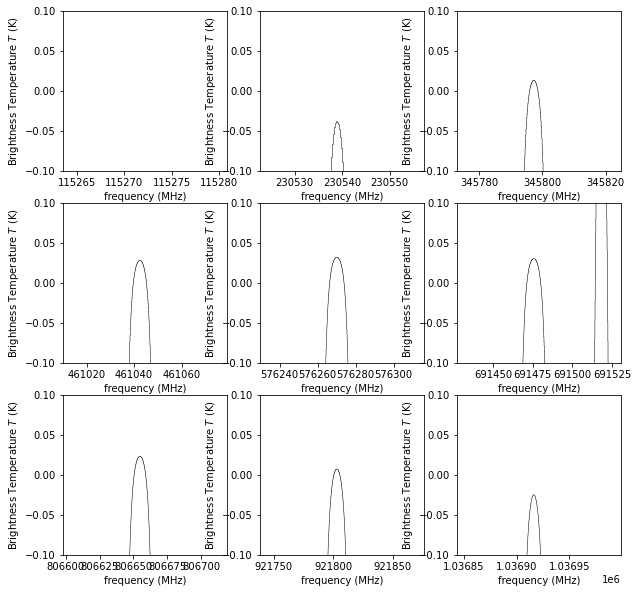

In [25]:
fig = pl.figure(figsize=(10,10))
for ii,(fmin, fmax) in enumerate(frequencies):
    if ii+1 > 9:
        break
    ax = pl.subplot(3,3,ii+1)
    diff.plotter(axis=ax, xmin=fmin, xmax=fmax)
    ax.set_ylim(-0.1, 0.1)

In [26]:
np.median(diff.data[~diff.data.mask])

-291.1940439002981

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0.05      , 0.05040816, 0.05081633, 0.05122449, 0.05163265,
        0.05204082, 0.05244898, 0.05285714, 0.05326531, 0.05367347,
        0.05408163, 0.0544898 , 0.05489796, 0.05530612, 0.05571429,
        0.05612245, 0.05653061, 0.05693878, 0.05734694, 0.0577551 ,
        0.05816327, 0.05857143, 0.05897959, 0.05938776, 0.05979592,
        0.06020408, 0.06061224, 0.06102041, 0.06142857, 0.06183673,
        0.0622449 , 0.06265306, 0.06306122, 0.06346939, 0.06387755,
        0.06428571, 0.06469388, 0.06510204, 0.0655102 , 0.06591837,
        0.06632653, 0.06673469, 0.06714286, 0.06755102, 0.06795918,
        0.06836735, 0.06877551, 0.06918367, 0.06959184, 0.07      ]),
 <BarContainer object of 49 artists>)

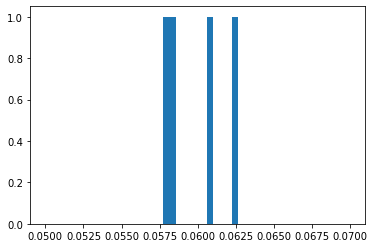

In [27]:
pl.hist(diff.data, bins=np.linspace(0.05,0.07))

In [28]:
np.median(diff.data[diff.data<0.055])

masked

In [29]:
#pl.plot(model_CDMS.data,    molsim_sp.data, ',')